In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## DenseNet Model

In [2]:
###-----------------
### Import Libraries
###-----------------

import os

import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


import tensorflow as tf

    
%matplotlib inline

In [3]:
###------------------
### Memory Management
###------------------

physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
###---------------------------------------
### Global  parameters and Hyperparamaters
###---------------------------------------

inpDir = '/content/drive/MyDrive/Computer Vision/inputs' # location where input data is stored
outDir = '/content/drive/MyDrive/Computer Vision/outputs' # location to store outputs
subDir = 'animals_orig' # location of the images
trainDir = 'train'
modelDir = '/content/drive/MyDrive/Computer Vision/models' # location to save model files
valDir = 'validation' # location related to this dataset
# altName = 'dropout_bn_no_bias_leaky_animals' # Model file name for this alternative

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
tf.random.set_seed(RANDOM_STATE)


EPOCHS = 100   # number of cycles to run

ALPHA = 0.01

BATCH_SIZE = 16

TEST_SIZE = 0.2

IMG_HEIGHT = 224

IMG_WIDTH = 224

FLIP_MODE = "horizontal_and_vertical"

# for rotation transformation 
ROTATION_FACTOR = (-0.1, 0.1) 

FILL_MODE = 'nearest'

ES_PATIENCE = 20 # if performance does not improve stop

LR_PATIENCE = 10 # if performace is not improving reduce alpha

LR_FACTOR = 0.5 # rate of reduction of alpha

RATE = 0.2


# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,6),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.brg

plt.rcParams.update(params) # update rcParams

## Helper Function

In [5]:

def fn_plot_hist(hist_df):
    
    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    '''
        
    # create figure and axis array
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)

    # take first axis
    ax = axes[0]

    # Plot Column 0 and 2 (Loss and validation loss)
    hist_df.plot(y = [hist_df.columns[0],hist_df.columns[2]], ax = ax, colormap=CMAP)

    # get minimum values for plotting
    lossmin = hist_df[hist_df.columns[0]].min()

    testmin = hist_df[hist_df.columns[2]].min()

    # little beautification
    txtstr = "Min {}: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(hist_df.columns[0],
                                                                          lossmin,
                                                                          testmin) #text to plot

    # place a text box in upper left in axes coords
    ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    # label the axes
    ax.set_xlabel("Epochs")

    ax.set_ylabel(hist_df.columns[0].capitalize())

    # grids make it look good
    ax.grid()
    
    # take second axis object
    ax = axes[1]

    # plot column 1 and 3 (accuracy and validation accuracy)
    hist_df.plot( y = [hist_df.columns[1], hist_df.columns[3]], ax = ax, colormap=CMAP)

    # little beautification
    accmin = hist_df[hist_df.columns[1]].max()
    testmin = hist_df[hist_df.columns[3]].max()
    txtstr = "Max {}: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(hist_df.columns[1],
                                                                                accmin,
                                                                                testmin) #text to plot

    # place a text box in upper left in axes coords
    ax.text(0.4, 0.5, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    # label the axes
    ax.set_xlabel("Epochs")
    
    ax.set_ylabel(hist_df.columns[1].capitalize())
    
    # grids make it look good
    ax.grid()
    
    # fit the subplot(s) in to the figure area
    plt.tight_layout()
    
    # display all open images
    plt.show()

In [6]:
# Function to plot number of classes in training and testing sets
def fn_plot_label(tr_ds, ts_ds):
    
    '''
        Args:
            tr_ds :  Training Dataset
            ts_ds : Testing dataset
        Returns : none
    '''

    # create figure
    plt.figure(figsize = (15,5))
    
    # create two subplots
    plt.subplot(1,2,1)

    # create array of training labels
    train_labels = tf.concat([y for x, y in tr_ds], axis = 0).numpy()
    
    # get unique labels and counts thereof
    unique, _, counts = tf.unique_with_counts(train_labels)
    
    # bar plot
    plt.bar(range(len(unique)), counts, align='center',color = 'DarkBlue', alpha = 0.7)
    
    # add title
    plt.title('Training Set')
    
    # add ticks on axis
    plt.xticks(range(len(unique)), class_names)
    
    # grids make it look good
    plt.grid()


    #pick second image
    plt.subplot(1,2,2)

    # create array of testing labels 
    val_labels = tf.concat([y for x, y in ts_ds], axis = 0).numpy()
    
    # get unique labels and counts thereof
    unique, _, counts = tf.unique_with_counts(val_labels)
    
    # bar plot
    plt.bar(range(len(unique)), counts, align='center', color = 'Orange', alpha = 0.7)
    
    # add title
    plt.title('Test Set')
    
    # add ticks
    plt.xticks(range(len(unique)), class_names)
    
    # grids make it look good
    plt.grid()
    
    # fit the subplot(s) in to the figure area
    plt.tight_layout()
    
    # display all open figures
    plt.show()

## Load Dataset

Images are under animal_orig

     - elefante_train 
     - farfalla_train 
     - mucca_train 
     - pecora_train 
     - scoiattolo_train

In [7]:
'''
    For reading from web link
'''

# import pathlib
# dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# data_dir = tf.keras.utils.get_file(origin=dataset_url,
#                                   fname='flower_photos',
#                                   untar=True)
# data_dir = pathlib.Path(data_dir)
'''
#     For reading from local directory
# '''
data_dir = os.path.join(inpDir, subDir, trainDir)

In [8]:
data_dir

'/content/drive/MyDrive/Computer Vision/inputs/animals_orig/train'

In [9]:
#list content of data_dir
os.listdir(data_dir)

['mucca_train',
 'elefante_train',
 'pecora_train',
 'farfalla_train',
 'scoiattolo_train']

In [10]:
# data_dir= '/home/dai/directory_env/input/animals_orig/train'

### Train and Test Datasets

In [11]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=TEST_SIZE,
    subset='training',
    seed= RANDOM_STATE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=TEST_SIZE,
    subset='validation',
    seed= RANDOM_STATE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)


Found 8196 files belonging to 5 classes.
Using 6557 files for training.
Found 8196 files belonging to 5 classes.
Using 1639 files for validation.


### Is it picking the class names?

In [12]:
class_names = train_ds.class_names
print('total ', len(class_names), class_names)

total  5 ['elefante_train', 'farfalla_train', 'mucca_train', 'pecora_train', 'scoiattolo_train']


In [13]:
train_ds.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

### Verify the data

To verify that the dataset looks correct, let's plot the first batch from the training set and display the class name below each image.


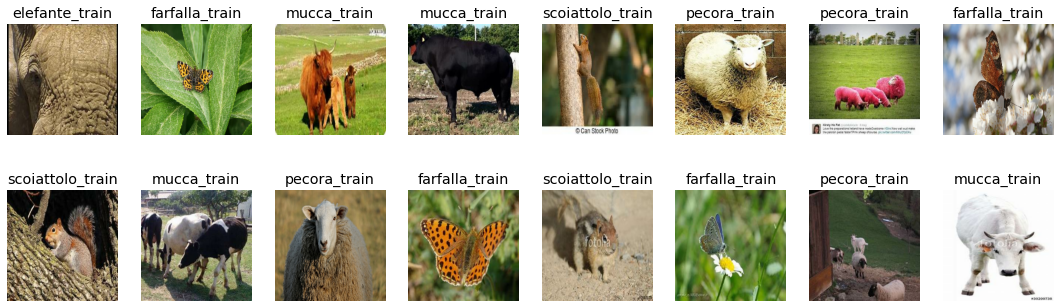

In [14]:
# set figure size
plt.figure(figsize=(15,5))

# take one batch of the dataset
for images, labels in train_ds.take(1):
    
    # iterate through the batch
    for i in range(BATCH_SIZE):
        
        # add a subplot
        plt.subplot(int(BATCH_SIZE/8), 8, i+1 )
        
        # switch off the grids
        plt.grid(False)
        
        # image_size may have converted these images to float
        plt.imshow(images[i].numpy().astype("uint8")) 
        
        # display class in the title
        plt.title(class_names[labels[i]])
        
        # no axis
        plt.axis("off")
        
    # fit the subplot(s) in to the figure area
    plt.tight_layout()
    
# display all open images    
plt.show()

In [15]:
# how many examples in each of the class
# fn_plot_label(train_ds, test_ds)

In [16]:
# pick the input_shape 

input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

## RandomZoom

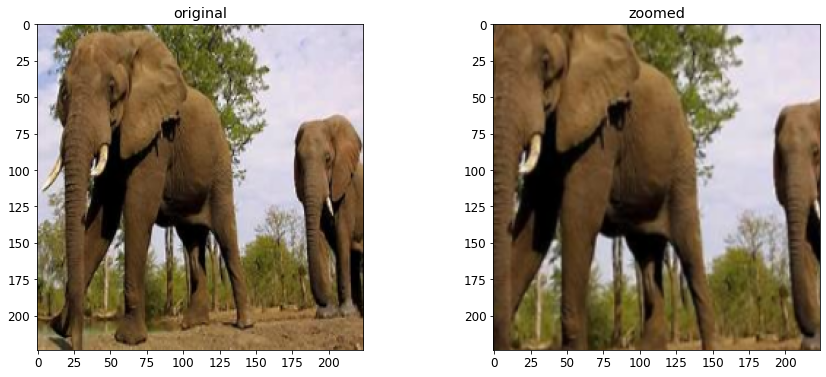

In [17]:
layer = tf.keras.layers.RandomZoom(height_factor=(-0.2,-0.2),
                                   width_factor=(-0.2,-0.2)
                                  )

plt.figure()

img_num = 3

for images, labels in train_ds.take(1):
    
    out_images = layer(images)
    
    plt.subplot(1,2,1)
    
    plt.title('original')
    
    plt.imshow(images[img_num].numpy().astype('uint8'))
    
    plt.subplot(1,2,2)
    
    plt.title('zoomed')
    
    plt.imshow(out_images[img_num].numpy().astype('uint8'))
 

## Random Rotation

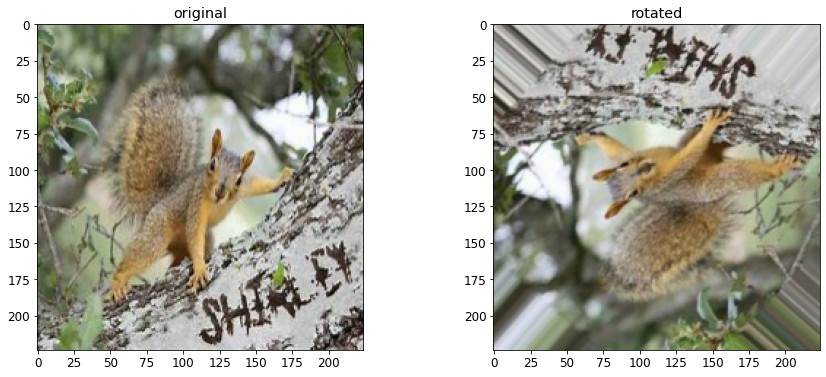

In [18]:
layer = tf.keras.layers.RandomRotation((-0.5, 0.5),
                                       fill_mode='nearest')

plt.figure()

img_num = 3

for images, labels in train_ds.take(1):
    
    out_images = layer(images)
    
    plt.subplot(1,2,1)
    
    plt.title('original')
    
    plt.imshow(images[img_num].numpy().astype('uint8'))
    
    plt.subplot(1,2,2)
    
    plt.title('rotated')
    
    plt.imshow(out_images[img_num].numpy().astype('uint8'))

### Standardize the data
The original RGB channel values are in the [0, 255] range. Resizing has converted those values into floats. Standardize values to be in the [0, 1] range by using the tf.keras.layers.experimental.preprocessing.Rescaling layer.

In [19]:
## Optimize for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# DenseNet Model 

![image.png](attachment:image.png)

In [20]:
densenet_model = tf.keras.applications.densenet.DenseNet169(
    include_top=False,
    weights='imagenet',
    input_shape=[IMG_HEIGHT, IMG_WIDTH, 3]
)

51877672/51877672 [==============================] - 3s 0us/step


In [21]:
for layer in densenet_model.layers:
    layer.trainable = False

# Early Stopping


In [22]:
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  restore_best_weights=True,
                                                  patience=ES_PATIENCE,
                                                  verbose=1)

# Kernel Initializer

In [23]:
krnl_init = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)

In [24]:
model = tf.keras.models.Sequential() # Sequential Model Initialization

model.add(tf.keras.layers.Rescaling(1. / 255.)) # scaling all images between 0 - 1

model.add(densenet_model) # added the DenseNet to our model





model.add(tf.keras.layers.Flatten()) # Flattening layer

# Dense Layer 1
model.add(tf.keras.layers.Dense(1664, 
                                kernel_initializer = krnl_init,
                                #kernel_regularizer=REGULAR,
                                #activation=D_ACTIVATION
                                ))


# model.add(tf.keras.regularizers.L2(l2=0.02)) # added Regularization

model.add(tf.keras.layers.BatchNormalization()) # Batch Normalization

model.add(tf.keras.layers.Activation("relu")) # Added activation function

model.add(tf.keras.layers.Dropout(0.3)) # Added DropOut 

model.add(tf.keras.layers.Dense(5)) # Output Layer



In [25]:
densenet_model.summary()

Model: "densenet169"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

### Model Compile

In [26]:
model.compile(optimizer='adam',
                       loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                       metrics=['accuracy'],
)

### Fitting the Model on data

In [ ]:
history = model.fit(train_ds,
                             validation_data=test_ds
                             ,batch_size=BATCH_SIZE,
                             epochs=EPOCHS,
                             callbacks= [early_callback],
                             verbose=2)

Epoch 1/100
410/410 - 1214s - loss: 0.2362 - accuracy: 0.9395 - val_loss: 0.1084 - val_accuracy: 0.9664 - 1214s/epoch - 3s/step
Epoch 2/100
410/410 - 43s - loss: 0.0216 - accuracy: 0.9930 - val_loss: 0.0756 - val_accuracy: 0.9774 - 43s/epoch - 104ms/step
Epoch 3/100
410/410 - 42s - loss: 0.0041 - accuracy: 0.9992 - val_loss: 0.0670 - val_accuracy: 0.9762 - 42s/epoch - 102ms/step
Epoch 4/100
410/410 - 42s - loss: 5.9935e-04 - accuracy: 1.0000 - val_loss: 0.0655 - val_accuracy: 0.9780 - 42s/epoch - 102ms/step
Epoch 5/100
410/410 - 41s - loss: 2.2837e-04 - accuracy: 1.0000 - val_loss: 0.0679 - val_accuracy: 0.9768 - 41s/epoch - 100ms/step
Epoch 6/100
410/410 - 41s - loss: 1.5148e-04 - accuracy: 1.0000 - val_loss: 0.0696 - val_accuracy: 0.9768 - 41s/epoch - 101ms/step
Epoch 7/100
410/410 - 41s - loss: 1.1236e-04 - accuracy: 1.0000 - val_loss: 0.0705 - val_accuracy: 0.9768 - 41s/epoch - 100ms/step
Epoch 8/100
410/410 - 41s - loss: 9.7074e-05 - accuracy: 1.0000 - val_loss: 0.0718 - val_accur

In [ ]:
res_df = pd.DataFrame(history.history)
res_df

,loss,accuracy,val_loss,val_accuracy
0,0.716904,0.818801,0.488865,0.877384
1,0.065130,0.979905,0.341114,0.911444
2,0.013056,0.998297,0.315101,0.916894
3,0.003145,0.999659,0.332065,0.918256
4,0.001681,1.000000,0.324155,0.912807
5,0.001063,1.000000,0.325562,0.914169
6,0.000742,1.000000,0.326495,0.918256
7,0.000590,1.000000,0.334541,0.918256
8,0.000445,1.000000,0.335114,0.918256
9,0.000402,1.000000,0.337579,0.919619


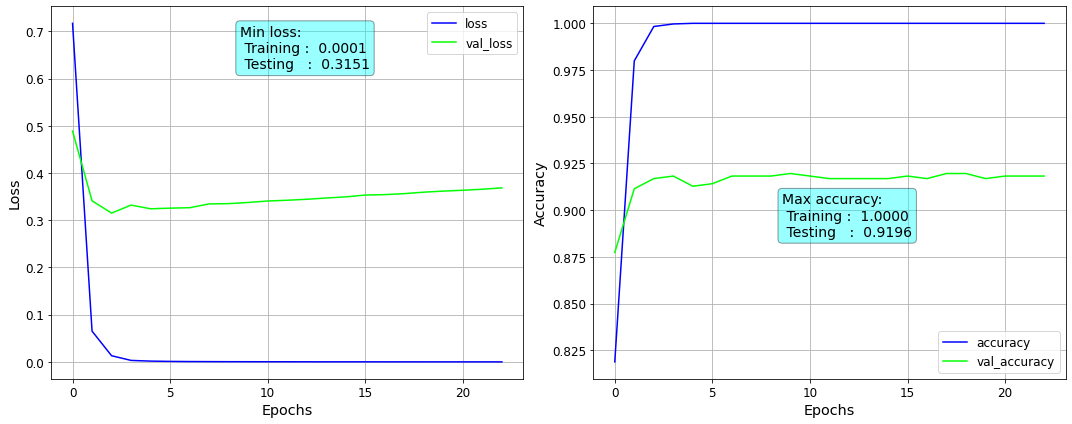

In [ ]:

fn_plot_hist(res_df)